In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
from scipy.stats import beta, chisqprob
from scipy.special import gamma as gammaf # This is dumb but better for the moment than fixing code against jon's
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from sys import maxint
from scipy.special import binom
from IPython.display import display, HTML
from sklearn.cross_validation import KFold


In [2]:
# Inline all plots to cell outputs
%matplotlib inline

In [3]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
    plt.legend(title='RG')
    plt.show() #change ticks to integers only

def plot_matrix(matrix, title='Matrix', vmax=None):
    n, m = matrix.shape
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
    plt.colorbar()
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(m)+0.5)
    ax.set_xticklabels(np.arange(n))
    ax.set_yticklabels(np.arange(m))
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

In [4]:
a=np.array([[1,2],[3,4]])
d=np.diag(a)

o=np.outer(d,d)
np.sqrt(o)*np.sqrt(o)
np.linalg.matrix_power(a,.5)

TypeError: exponent must be an integer

Bradscratch stuff below here

In [6]:
# Data reading and distance calculation utilities
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def package_and_sort(matrix, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
#     df = pd.DataFrame(matrix, index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)
    df = pd.DataFrame(matrix, index=arrays, columns=arrays).sortlevel(level=1).sortlevel(level=1, axis=1)
    df.index.names=["group", "library"]
    return df


In [7]:
# Getting the truth matrix after precomputing the distances.
# Because this can be cached too, but is faster to get
# Also more frequesnt to change
# Therefore helps to be lower down in the stack
def make_truth_matrix(groups, libraries):
    n_groups = len(groups)
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i == j:
                truth[i,j] = -1  # sentinal value so the diagonal doesn't bias with evaluation metrics
            elif libraries[i] == libraries[j]:
                truth[i,j] = 1
    return package_and_sort(truth, groups, libraries)

print "Getting the truth"
# truth = make_truth_matrix(groups, libraries)

Getting the truth


In [8]:
# Funcions supporting a likelihoods ratio test.
def fit_beta_distributions(distance, truth):
    # In practice my true-diff-library values are often all 0.0. Faux counts save my true-different beta dist from being entilely 0.
    faux_counts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
    
    # Fit a beta distribution to the true positives
    true_positives=np.append(distance.values[truth.values>0], faux_counts)
    
    alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
    dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object

    # Fit a beta distribution to the true negatives
    true_negatives=np.append(distance.values[truth.values==0] + 10**-27, faux_counts)
    print true_negatives
    alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
    dNeg = beta(alphaN, betaN, locN, scaleN)
    return {'positive': dPos, 'negative': dNeg}

# Likelihood ratio test.
def calculate_log_likelihoods_ratio(x, distributions):
    dPos = distributions['positive']
    dNeg = distributions['negative']
    LLalt = np.log(dPos.pdf(x)) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    LLnull = np.log(dNeg.pdf(x)) # log likelihood that our 'different-library' distribution is the best model
    LLratio = LLalt - LLnull
    return LLratio

get_log_likeihoods = np.vectorize(calculate_log_likelihoods_ratio)

def calculate_log_LLR_probability(x, distributions):
    LLR = calculate_log_likelihoods_ratio(x, distributions)
    test_statistic = 2*LLR # test statistic follows chi-square distribution with degrees of freedom 0 (since # parameters equal)
    return chisqprob(test_statistic, 1) # TODO - I get NaN when DF = 0!!!

def LLR_is_significant(x, distributions):
    return (calculate_log_LLR_probability(x, distributions) < 0.5)

In [9]:
# Evaluation function + utilities
def summarize_result(result, expected, n_groups):
    all_positives = result[expected > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[expected == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    labels = ["p(same-library | truly same-library)", "p(different-library | truly different-library)", "Rand index"]
    return pd.DataFrame([true_positive_rate, true_negative_rate, rand_index], index=labels, columns=["Value"])

def plot_distance_histogram(distances, dists, truth):
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    dPos = dists['positive']
    dNeg = dists['negative']

    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    plt.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    plt.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    
    # Add beta function pdf for same-library and different-library models
    x = np.linspace(dPos.ppf(0), dPos.ppf(0.99), 100)
    plt.plot(x, dPos.pdf(x), 'r', lw=3, alpha=0.6)
    plt.plot(x, dNeg.pdf(x), 'b', lw=3, alpha=0.8)
    
    plt.ylim(ymax=40)
    plt.legend(loc='upper right')
    plt.title('Distribution of Pairwise Distances')
    plt.show()

def is_greater_than(x, threshold):
    return 1 if x > threshold else 0

apply_threshold = np.vectorize(is_greater_than)

def get_false_calls(distances, truth, results, n_groups):
    false_positives = []
    false_negatives = []
    for i in xrange(n_groups):
        for j in xrange(i, n_groups):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j:
                if obs > exp:
                    false_positives.append([i, j, obs, exp, distances.index[i], distances.index[j], dist])
                elif obs < exp:
                    false_negatives.append([i, j, obs, exp, distances.index[i], distances.index[j], dist])
    return (false_positives, false_negatives)

# Primary evaluation function
def evaluate(distances, truth, threshold, n_groups):
    display(HTML('<h5>Max distance</h5>'))
    print np.max(distances.values)
    
    result = apply_threshold(distances, threshold)
    false_pos, false_neg = get_false_calls(distances, truth, result, n_groups)
    
    distributions = fit_beta_distributions(distances, truth)
    LLR_matrix = get_log_likeihoods(distances, distributions)
    LLR_significance = LLR_is_significant(distances, distributions)
    LLR_false_pos, LLR_false_neg = get_false_calls(distances, truth, LLR_significance, n_groups)
     
    display(HTML('<h5>Threshold Evaluation Metrics</h5>'))
    display(summarize_result(result, truth.values, n_groups))
    display(HTML('<h5>Log-Likelihood Ratio Test Evaluation Metrics</h5>'))
    display(summarize_result(LLR_significance, truth.values, n_groups))
    display(HTML('<h5>Threshold False Positives</h5>'))
    for fp in false_pos: print fp
    display(HTML('<h5>Log-Likelihood Ratio Test False Positives</h5>'))
    for fp in LLR_false_pos: print fp
    display(HTML('<h5>Threshold False Negatives</h5>'))
    for fn in false_neg: print fn
    display(HTML('<h5>Log-Likelihood Ratio Test Negatives</h5>'))
    for fn in LLR_false_neg: print fn
    plot_matrix(distances, title='Pairwise Similarity Values')
    plot_matrix(result, title='test: Similarity Exceeds Threshold')
    plot_matrix(LLR_matrix, title='Log Likelihood Ratios (alt / null)')
    plot_matrix(LLR_significance, title='LLR test p-value < 0.05')
    plot_distance_histogram(distances, distributions, truth.values)

In [10]:
# threshold getter functions

# TODO - what if min <= max????
def min_max_mean(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

def exhaustive_search(distances, truth):
    n_groups = len(distances.index.values)
    sorted_dists = np.sort(np.unique(distances.values))
    max_rand_index = 0
    max_rand = 0.0
    for index in xrange(len(sorted_dists)):
        results = apply_threshold(distances, sorted_dists[index])
        rand = summarize_result(results, truth, n_groups).loc["Rand index"].values[0]
        if rand > max_rand: max_rand_index = index
    return sorted_dists[max_rand_index]
    
# Generic outer function - Dont think I need
# def get_threshold(distances, truth, threshold_func):
#     return threshold_func(distances, truth)

In [ ]:
# exhaustive_search(ap_distance, truth)


In [11]:
# Perform the experiment
def run_experiment(distances, n_groups, distance_label, truth, get_threshold, combine_threshold, evaluate_subsets):
    
    display(HTML("<h3>Evaluating similarity function: {0}</h3>".format(distance_label)))
    display(HTML("<h3>Threshold function: {0} | Threshold combiner: {1}</h3>".format(get_threshold.__name__, combine_threshold.__name__)))
    
    # perform 5-fold cross-validation
    thresholds = []
    kf = KFold(n_groups, n_folds=5, shuffle=False)
    subset_count = 1
    for train, test in kf:
        # Select the training distance/truth values
        train_dists = distances.iloc[train, train]
        train_truth = truth.iloc[train, train]
        
        # Derive the subset-threshold
        threshold = get_threshold(train_dists, train_truth.values)
        thresholds.append(threshold)
        
        # Select the training distance/truth values, and evaluate the threshold
        if evaluate_subsets:
            # Provide some context on the subset, threshold, evaluations
            display(HTML("<h4>Evaluating Subset {}</h4>".format(subset_count)))
            print "Training subset indices"
            print train
            print "Testing subset indices"
            print test
            display(HTML("<h5>Subset Threshold = {0:.2f}</h5>".format(round(threshold,2))))
            
            # Select the test distance/truth values for performance evaluation purposes
            test_dists = distances.iloc[test, test]
            test_truth = truth.iloc[test, test]
            evaluate(test_dists, test_truth, threshold, len(test))
        subset_count += 1

    # Combine partition level thresholds via provided function
    combined_threshold = combine_threshold(thresholds)
    display(HTML("<h3>Evaluating combined threshold</h3>"))
    display(HTML("<h4>Combined Threshold = {0:.2f}</h4>".format(round(combined_threshold,2))))
    
    # DISPLAY SUMMARY INFO ABOUT THE THRESHOLD- see pandas dataframe summarize
    display(pd.Series(thresholds))
    
    # Evaluate combined threshold over entire dataset
    evaluate(distances, truth, combined_threshold, n_groups)
    display(HTML("<hr>"))

In [ ]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
# ap_distance = pd.read_csv("test_10_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])

# threshold_getters = [min_max_mean, exhaustive_search]
# for threshold_getter in threshold_getters:
#     run_experiment(ap_distance, "All Pairs Affinity", groups, truth, threshold_getter, np.mean, True)    



In [12]:

def limited_pairs(table, n_groups, k):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j, up to a certain read type size k (symmetrized).'''
    lp_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        if len(item) <= k:
            l = len(item[0])
            for i in xrange(l-1):
                for j in xrange(i+1,l):
                    lp_matrix[item[0][i],item[0][j]] += item[1]
    return (lp_matrix + np.tril(lp_matrix.T))/2


def random_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of each read type assigned to the 
       random group i,j drawn from the larger read type (symmetrized).'''
    rp_matrix = np.zeros((n_groups, n_groups))
    faf = np.zeros((n_groups, n_groups))
    for item in table.items():#[:6]:
        tup = item[0]
        if len(tup) > 1:
            pair = np.random.choice(tup, size=2, replace=False)
            rp_matrix[min(pair), max(pair)] += item[1]
    return (rp_matrix + np.tril(rp_matrix.T))/2

def random_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(random_pairs(table, n_groups))

def unlimited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, maxint))

def ten_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 10))

def five_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 5))

def four_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 4))

def three_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 3))

def two_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 2))

In [ ]:
# rp_affinity = random_pairs_affinity(table, len(groups))
# ten_limit = ten_limited_affinity(table, len(groups))
# five_limit = five_limited_affinity(table, len(groups))
# four = package_and_sort(zero_diag(four_limited_affinity(table, len(groups))), groups, libraries)
# three = package_and_sort(zero_diag(three_limited_affinity(table, len(groups))), groups, libraries)
# two = package_and_sort(zero_diag(two_limited_affinity(table, len(groups))), groups, libraries)
# rp = package_and_sort(zero_diag(rp_affinity), groups, libraries)
# ten = package_and_sort(zero_diag(ten_limit), groups, libraries)
# five = package_and_sort(zero_diag(five_limit), groups, libraries)
# print "done"

# things = { "Random Pairs Affinity": rp, "Ten Limited All Pairs": ten, "Five Limited All Pairs": five , "Four limited": four, "Three Limited": three, "Two Limited": two}

# for test_label, distance in things.iteritems():
#     run_experiment(distance, test_label, truth, min_max_mean, np.mean, False) 

In [ ]:
# np.sum(truth.values[truth.values>0])

In [13]:
def evaluate_all_distances(distance_files, metadata_file):
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
    display(HTML("<h4>Truth Matrix</h4>"))
    plot_matrix(truth)

    
    for test_label, test_file in distance_files.iteritems():
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
#     print test_label, 
#     print np.sum(distance.values),    
#     print 100 * (np.sum(distance.values) / 798.0),
#     print np.max(distance.values)
        run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False) 

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_libraries.five.csv", \
              "Four limited Affinity" : "test_10_libraries.four.csv", \
              "Three limited Affinity" : "test_10_libraries.three.csv", \
              "Two limited Affinity" : "test_10_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

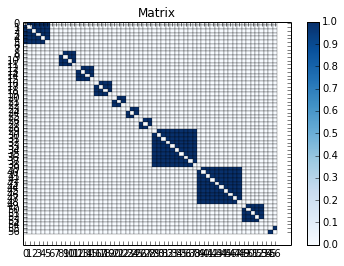

0    0.000186
1    0.000186
2    0.000186
3    0.000186
4    0.169062
dtype: float64

0.999412198572
[  1.00000000e-27   1.00000000e-27   1.00000000e-27 ...,   7.00000000e-01
   8.00000000e-01   9.00000000e-01]


,Value
p(same-library | truly same-library),0.944056
p(different-library | truly different-library),1.000000
Rand index,0.994987


,Value
p(same-library | truly same-library),0.937063
p(different-library | truly different-library),1.000000
Rand index,0.994361


[49, 52, 0, 1.0, ('B00RE.2', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.032169733656699999]
[49, 53, 0, 1.0, ('B00RE.2', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00043252129471800006]
[50, 51, 0, 1.0, ('B00RE.3', 'Pond-63707'), ('B00RE.4', 'Pond-63707'), 0.0291683261209]
[50, 52, 0, 1.0, ('B00RE.3', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.024395803555799997]
[50, 53, 0, 1.0, ('B00RE.3', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00037102674448999997]
[51, 52, 0, 1.0, ('B00RE.4', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.019775174569599999]
[51, 53, 0, 1.0, ('B00RE.4', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00047460121715400003]
[52, 53, 0, 1.0, ('B09N0.7', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.0080962063921600005]


[49, 51, False, 1.0, ('B00RE.2', 'Pond-63707'), ('B00RE.4', 'Pond-63707'), 0.037098673807500003]
[49, 52, False, 1.0, ('B00RE.2', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.032169733656699999]
[49, 53, False, 1.0, ('B00RE.2', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00043252129471800006]
[50, 51, False, 1.0, ('B00RE.3', 'Pond-63707'), ('B00RE.4', 'Pond-63707'), 0.0291683261209]
[50, 52, False, 1.0, ('B00RE.3', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.024395803555799997]
[50, 53, False, 1.0, ('B00RE.3', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00037102674448999997]
[51, 52, False, 1.0, ('B00RE.4', 'Pond-63707'), ('B09N0.7', 'Pond-63707'), 0.019775174569599999]
[51, 53, False, 1.0, ('B00RE.4', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.00047460121715400003]
[52, 53, False, 1.0, ('B09N0.7', 'Pond-63707'), ('B09N0.8', 'Pond-63707'), 0.0080962063921600005]


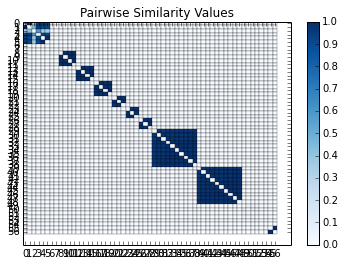

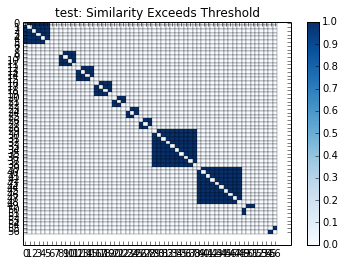

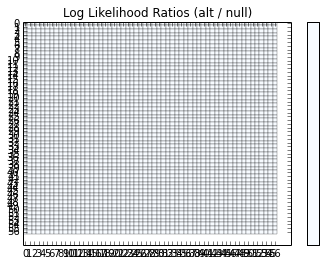

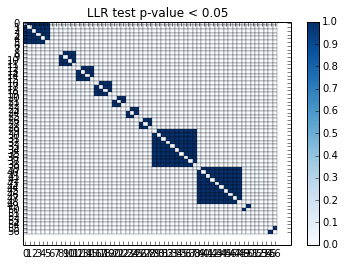

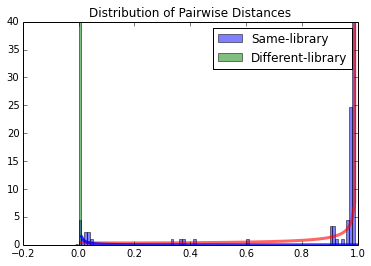

0    0.000067
1    0.000067
2    0.000067
3    0.000067
4    0.440028
dtype: float64

1.3782186075


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'beta' requires that 0 < x < 1 for each x in `data`.

In [22]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_exome_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_exome_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_exome_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [41]:
distances = pd.read_csv(ten_libraries_distances["Random Pairs Affinity"], header=[0,1], index_col=[0,1])
meta = read_metadata(ten_libraries_metadata)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
np.max(distances.values)
distances.values[distances.values>1]

array([ 1.19995139,  1.00596365,  1.18824018,  1.00596365,  1.18824018,
        1.17774909,  1.19995139,  1.17774909,  1.01131894,  1.06364347,
        1.01131894,  1.06364347,  1.14869187,  1.14869187,  1.2145164 ,
        1.2145164 ,  1.11478474,  1.11478474,  1.09448511,  1.09448511,
        1.06655847,  1.06655847,  1.1942138 ,  1.1942138 ,  1.04570506,
        1.18634787,  1.147879  ,  1.00191945,  1.04570506,  1.25597645,
        1.10181151,  1.05769297,  1.19593309,  1.25597645,  1.15222105,
        1.22067048,  1.04847647,  1.27979373,  1.18634787,  1.10181151,
        1.15222105,  1.34629868,  1.1067441 ,  1.20802665,  1.03238472,
        1.147879  ,  1.22363906,  1.13457462,  1.15792905,  1.05769297,
        1.22067048,  1.34629868,  1.22363906,  1.10097054,  1.0425147 ,
        1.09185625,  1.1067441 ,  1.10097054,  1.19869715,  1.19593309,
        1.04847647,  1.20802665,  1.13457462,  1.0425147 ,  1.19869715,
        1.27979373,  1.15792905,  1.09185625,  1.00191945,  1.03

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_weird_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_weird_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_weird_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_weird_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_weird_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_weird_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_weird_libraries.ten.csv", \
              "Five limited Affinity" : "test_weird_libraries.five.csv", \
              "Four limited Affinity" : "test_weird_libraries.four.csv", \
              "Three limited Affinity" : "test_weird_libraries.three.csv", \
              "Two limited Affinity" : "test_weird_libraries.two.csv" \
             }

ten_libraries_metadata = "test_weird_libraries.read_groups.json"

# evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_agilent_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_agilent_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_agilent_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_agilent_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_agilent_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_agilent_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_agilent_libraries.ten.csv", \
              "Five limited Affinity" : "test_agilent_libraries.five.csv", \
              "Four limited Affinity" : "test_agilent_libraries.four.csv", \
              "Three limited Affinity" : "test_agilent_libraries.three.csv", \
              "Two limited Affinity" : "test_agilent_libraries.two.csv" \
             }

ten_libraries_metadata = "test_agilent_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# meta = read_metadata(ten_libraries_metadata)
# for (numb, read_group) in meta.iteritems():
#     print numb, read_group[u'mReadGroupId'], read_group['mAttributes']['LB']

In [14]:
# Read in the data and precompute distance
# Just splitting this off to cache the values
print "Reading inputs"
# meta = read_metadata('test_2_libraries.tabledata.json.read_groups.json')
# table = read_table('test2libs.tabledata.json')  

# meta = read_metadata('test_10_libraries.read_groups.json')
# table = read_table('test_10_libraries.table.json')

meta = read_metadata('test_exome_libraries.read_groups.json')
table = read_table('test_exome_libraries.table.json')  

groups, libraries = get_groups_and_libraries(meta)

Reading inputs


In [40]:
print "Calculating pairwise distances"
ap_affinity = package_and_sort(zero_diag(all_pairs_affinity(table, len(groups))), groups, libraries)

Calculating pairwise distances


In [31]:
print "calculating fixed distances"
# ap_affinity_fixed = package_and_sort(zero_diag(all_pairs_affinity_fixed(table, len(groups))), groups, libraries)

calculating fixed distances


In [32]:
def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs_fixed(table, n_groups))

def all_pairs_fixed(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T) + np.diagonal(ap_matrix))/2 

In [16]:
groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
# ap_matrix = np.zeros((n_groups,n_groups))
# for item in table.items():
#     l = len(item[0])
#     for i in xrange(l-1):
#         for j in xrange(i+1,l):
#             ap_matrix[item[0][i],item[0][j]] += item[1]

            
 

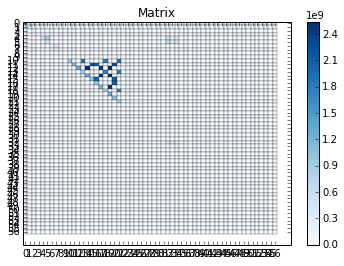

1187351460.0


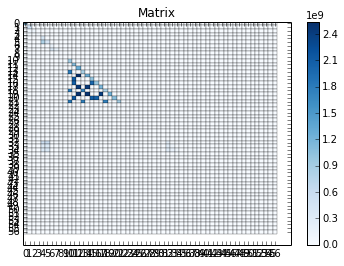

1187351460.0


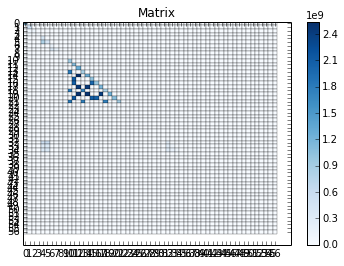

1187351460.0


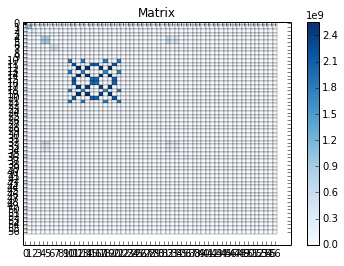

2374702920.0


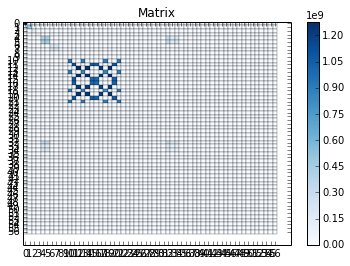

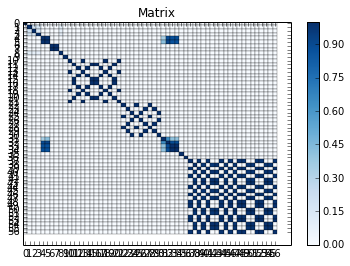

1.0
1.00028927317


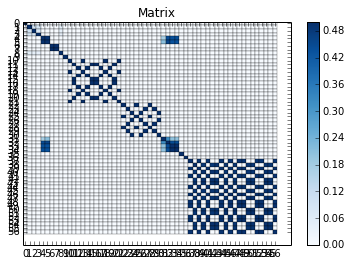

0.5
0.500144636587


In [34]:
            
plot_matrix(ap_matrix)
print ap_matrix[0,0]
plot_matrix(ap_matrix.T)
print ap_matrix.T[0,0]
plot_matrix(np.tril(ap_matrix.T))
print np.tril(ap_matrix.T)[0,0]
plot_matrix(ap_matrix + np.tril(ap_matrix.T))
print (ap_matrix + np.tril(ap_matrix.T))[0,0]
raw = (ap_matrix + np.tril(ap_matrix.T))/2
plot_matrix((ap_matrix + np.tril(ap_matrix.T))/2)
((ap_matrix + np.tril(ap_matrix.T))/2)[0,0]
orig = normalize_by_diagonal(((ap_matrix + np.tril(ap_matrix.T))/2))
plot_matrix(normalize_by_diagonal(((ap_matrix + np.tril(ap_matrix.T))/2)))
print normalize_by_diagonal(((ap_matrix + np.tril(ap_matrix.T))/2))[0,0]
np.max(normalize_by_diagonal(((ap_matrix + np.tril(ap_matrix.T))/2)))
print orig[10,13]

def normalize_by_diagonal2(matrix):
    diag = 2 * np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

plot_matrix(normalize_by_diagonal2(((ap_matrix + np.tril(ap_matrix.T))/2)))
floof = normalize_by_diagonal2(((ap_matrix + np.tril(ap_matrix.T))/2))
print floof[0,0]
np.max(normalize_by_diagonal2(((ap_matrix + np.tril(ap_matrix.T))/2)))
print floof[10,13]
# ok_some_dists = (package_and_sort(zero_diag(normalize_by_diagonal(((ap_matrix + np.tril(ap_matrix.T))/2))), groups, libraries))

# # display(ok_some_dists)
# plot_matrix(raw)
# plot_matrix(orig)
# # plot_matrix(ok_some_dists)
# farp = ok_some_dists
# farp[ok_some_dists <= 1] = 0
# orig[orig <= 1] = 0
# plot_matrix(orig)

# print orig[10]
# print raw[10]
# print orig[10,13]
# print raw[10,13]

# print
# print orig[4,5]
# print raw[4,5]




# diag = np.diagonal(raw)
# print diag
# denom = np.sqrt(np.outer(diag, diag))
# plot_matrix(raw)
# plot_matrix(np.outer(diag,diag))
# plot_matrix(denom)
# plot_matrix(raw/denom)


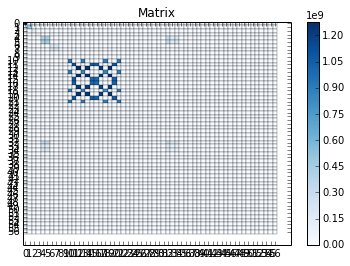

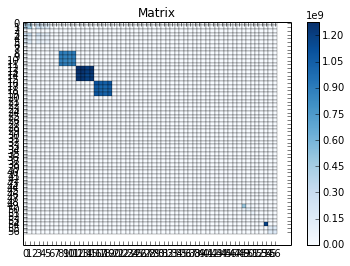

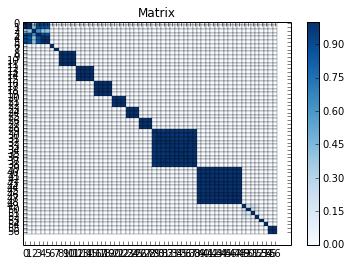

1.00138384723
[  3.79211168e+08   4.34741783e+08   2.00915000e+05   2.35203019e+08
   8.94392620e+07   8.79026560e+07   2.32847100e+07   2.40756530e+07
   9.17250212e+08   8.70332624e+08   8.49308879e+08   9.02349350e+08
   1.27920268e+09   1.26216152e+09   1.17159696e+09   1.22988530e+09
   1.10609024e+09   1.00744176e+09   9.81727412e+08   1.06652572e+09
   5.53237200e+06   6.25532900e+06   5.49429300e+06   9.45836100e+06
   1.03271460e+07   9.44062800e+06   9.66520700e+06   1.05890920e+07
   9.72569500e+06   2.05231700e+06   3.16066200e+06   3.12147200e+06
   2.59816200e+06   2.53754500e+06   2.60081000e+06   2.73506900e+06
   2.54230200e+06   2.34765700e+06   2.32276300e+06   3.37023800e+06
   6.55407400e+06   6.60480000e+06   4.23990600e+06   5.08990300e+06
   5.14641900e+06   5.51869900e+06   5.04439500e+06   4.53574100e+06
   4.44506100e+06   4.94389187e+08   1.22251347e+08   7.76967390e+07
   1.19636750e+07   1.10600000e+03   1.18735146e+09   1.56287362e+08
   1.65277277e+08]


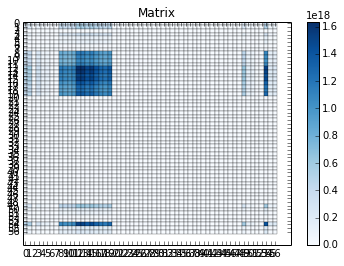

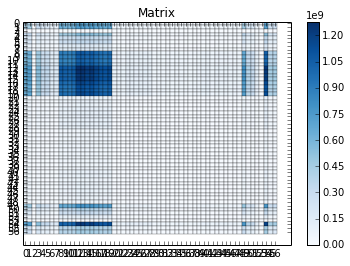

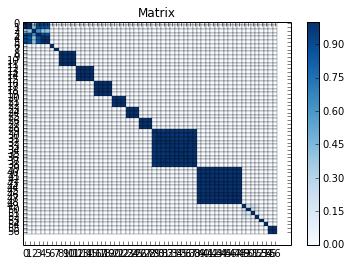

1.0013838472258254

In [35]:
raw = (ap_matrix + np.tril(ap_matrix.T))/2
plot_matrix(raw)
sortee = package_and_sort(raw, groups, libraries)
plot_matrix(sortee)
foof = normalize_by_diagonal(sortee.values)
plot_matrix(foof)
print np.max(foof)


diag = np.diagonal(sortee)
print diag
denom = np.sqrt(np.outer(diag, diag))
plot_matrix(np.outer(diag,diag))
plot_matrix(denom)
plot_matrix(sortee.values/denom)
np.max(sortee.values/denom)

In [36]:
print sortee.values[10,10]
print sortee.values[10,11]
print foof[10,10]
print foof[10,11]

849308879.0
876217316.0
1.0
1.00090220139


In [28]:
def exact_tuple_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        if len(item[0]) == 2:
            for i in item[0]:
                rg_sizes[i] += item[1]
    return rg_sizes

In [29]:
exacts = exact_pairs_affinity(table, n_groups)
print "woot"
rg_sizes = group_sizes(table, n_groups)
tuple_sizes= exact_tuple_sizes(table, n_groups)
exacts2 = exact_pairs_affinity2(table, n_groups, tuple_sizes)
print "woot"

woot
woot


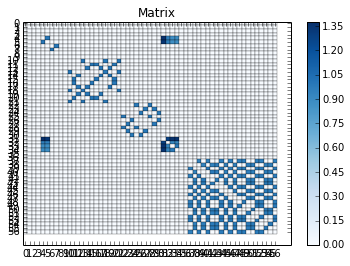

1.3782186075
1.3782186075


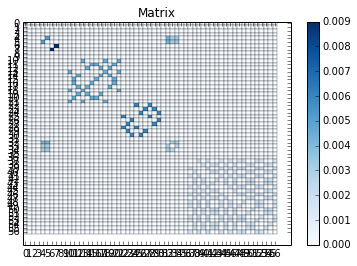

0.00900201808975
0.0180225375228
[808459631 516172126 192327390 139657132 677309244 709234950 318326712
 326334096  39508333      7328 121585358 132597983 143922254 115850748
 137785542 127528733 127034476 137471779 115586512 140164541 129214816
 117625883  61088387  62765605  44251316  64115390  46996883  65813164
  61342999  62890073  44165619   6128334 495322836 326534282 324160999
  43595399  46889991  36659384  25585491  52377842  32053512  51866917
  31872637  29024273  42011044  28829371  45995049  28975909  46332341
  48235250  30017352  28682452  45990720  43302089  27803452  27571076
  42960559]
121585358
115850748
57
[297380528 169425974  69717588  50199248 123618450 128725672  98369100
 100773044  13120556      2154  24667226  26300610  28089814  23474368
  26788782  25243506  25319188  27005468  23523298  27404796  25663404
  23821012  21429462  21830290  14644194  22497222  15573000  22881058
  21514820  21863612  14638646    963170  88015610  57234688  56857274
  1650359

In [36]:
plot_matrix(zero_diag(exacts))
print np.max(zero_diag(exacts))
print np.max(exacts)

plot_matrix(zero_diag(exacts2))
print np.max(zero_diag(exacts2))
print np.max(exacts2)

print rg_sizes
print rg_sizes[10]
print rg_sizes[13]
print len(rg_sizes)

print tuple_sizes
print np.outer(tuple_sizes, tuple_sizes)
print tuple_sizes[10]
print tuple_sizes[13]
print len(tuple_sizes)



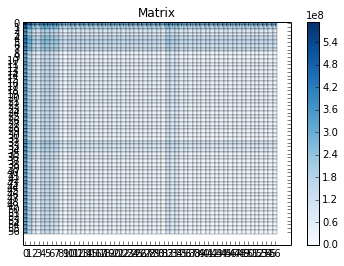

466806502.0
466806502.0
466806502


In [40]:
summed_sizes = np.zeros((n_groups, n_groups))
for i in xrange(len(tuple_sizes)):
    for j in xrange(len(tuple_sizes)):
        summed_sizes[i,j] = tuple_sizes[i] + tuple_sizes[j]
plot_matrix(summed_sizes)


print summed_sizes[1,0]
print summed_sizes[0,1]
print tuple_sizes[0] + tuple_sizes[1]

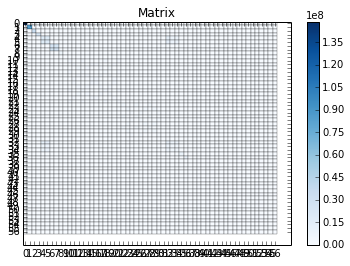

148690264.0
594761056.0


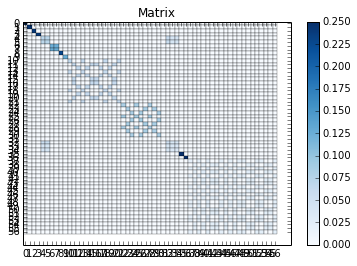

0.25
0.25
0.12486258057


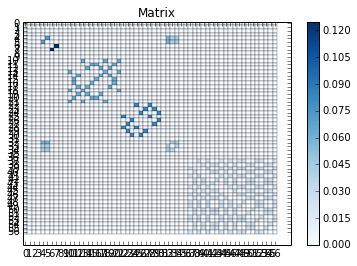

1.0
1.0
0.998169245311


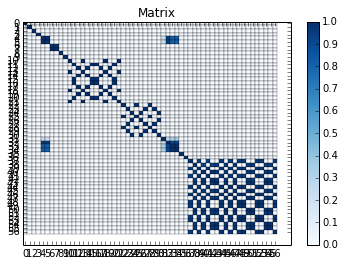

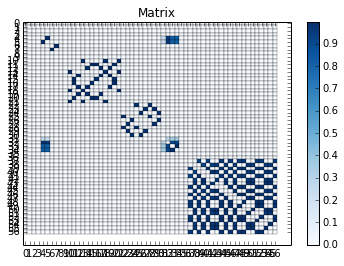

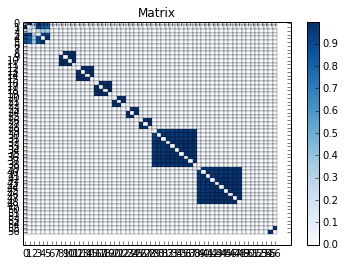

[  1.00000000e-27   1.00000000e-27   1.00000000e-27 ...,   7.00000000e-01
   8.00000000e-01   9.00000000e-01]


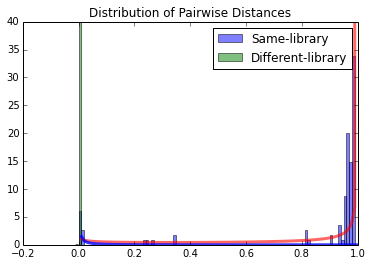

In [50]:
pairs = exact_pairs(table, n_groups)
plot_matrix(pairs)

print pairs[0,0]
print summed_sizes[0,0]

divided = pairs / summed_sizes

plot_matrix(divided)

print divided[0,0]
print np.max(divided)
print np.max(zero_diag(divided))

plot_matrix(zero_diag(divided))

normed = normalize_by_diagonal(divided)
print normed[0,0]
print np.max(normed)
print np.max(zero_diag(normed))
plot_matrix(normed)
plot_matrix(zero_diag(normed))

packaged = package_and_sort(zero_diag(normed), groups, libraries)
plot_matrix(packaged)

truth = make_truth_matrix(groups, libraries)

distribs = fit_beta_distributions(packaged, truth)
plot_distance_histogram(packaged, distribs, truth.values)

2023090000


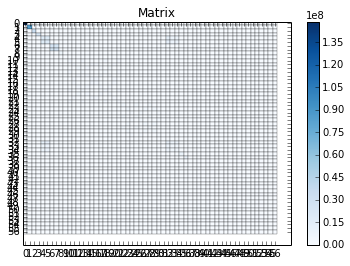

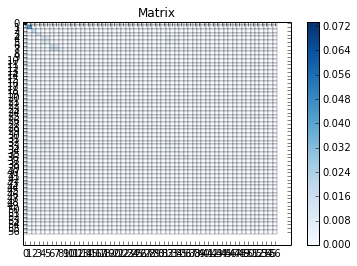

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.]
1.0
1.3782186075
1.3782186075


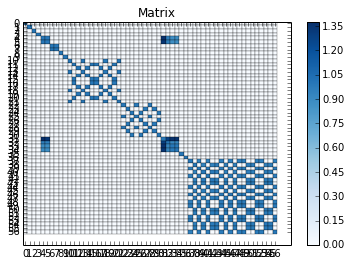

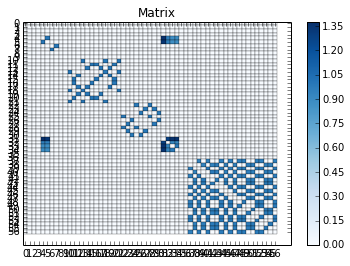

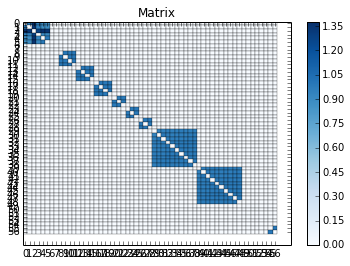

FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'beta' requires that 0 < x < 1 for each x in `data`.

In [73]:
total_reads = 0
for item in table.items():
    if len(item[0]) == 2:
        total_reads += 2 * item[1]
print total_reads

plot_matrix(pairs)

div = pairs / total_reads
plot_matrix(div)

normed = normalize_by_diagonal(div)
print np.diagonal(normed)
print normed[0,0]
print np.max(normed)
print np.max(zero_diag(normed))
plot_matrix(normed)
plot_matrix(zero_diag(normed))

packaged = package_and_sort(zero_diag(normed), groups, libraries)
plot_matrix(packaged)

truth = make_truth_matrix(groups, libraries)

distribs = fit_beta_distributions(packaged, truth)
plot_distance_histogram(packaged, distribs, truth.values)

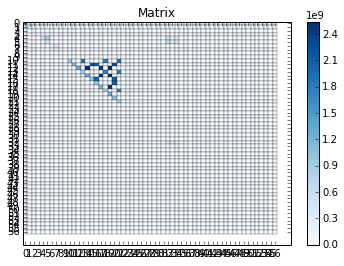

917250212.0
1787483943.0
[  1.18735146e+09   4.94389187e+08   1.22251347e+08   7.76967390e+07
   3.79211168e+08   4.34741783e+08   1.56287362e+08   1.65277277e+08
   1.19636750e+07   1.10600000e+03   9.17250212e+08   1.10609024e+09
   1.27920268e+09   8.70332624e+08   1.26216152e+09   1.00744176e+09
   9.81727412e+08   1.17159696e+09   8.49308879e+08   1.22988530e+09
   1.06652572e+09   9.02349350e+08   9.66520700e+06   9.45836100e+06
   5.53237200e+06   1.05890920e+07   6.25532900e+06   1.03271460e+07
   9.72569500e+06   9.44062800e+06   5.49429300e+06   2.00915000e+05
   2.35203019e+08   8.94392620e+07   8.79026560e+07   2.32847100e+07
   2.40756530e+07   3.37023800e+06   2.05231700e+06   6.55407400e+06
   3.16066200e+06   6.60480000e+06   3.12147200e+06   2.59816200e+06
   4.23990600e+06   2.53754500e+06   5.08990300e+06   2.60081000e+06
   5.14641900e+06   5.51869900e+06   2.73506900e+06   2.54230200e+06
   5.04439500e+06   4.53574100e+06   2.34765700e+06   2.32276300e+06
   4.4450

In [39]:
plot_matrix(ap_matrix)
print ap_matrix[10,10]
print ap_matrix[10,13]
print np.diag(ap_matrix)
print np.diag(ap_matrix) * 2